# Learning a 3-Layer Neural Network (NN)

This ipynb file contains the Programming for HW6.

Your task is to implement a multi-class classification model using Neural Networks to recognize handwritten numbers (0-9). You are asked to not only complete the Forward Propagation and the cost function, but also implement the Backpropagation algorithm to complete the 3-layer neural network (NN) model.

The NN has 3 layers:
- L1: 401 = 400 (20x20) features + 1 bias
- L2: 25 + 1 bias
- L3: 10 classification labels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
# Load the data (in .mat format)
from scipy.io import loadmat
data = loadmat('hw6_data.mat')

X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

## Visualize data

Load some functions to visualize a 10x10 matrix of handwritten numbers.

In [3]:
import scipy.misc # Used to show matrix as an image
import random  # To pick random images to display
import matplotlib.cm as cm # Used to display images in a specific colormap
from PIL import Image

def getDatumImg(row):
    # Function that is handed a single np array with shape 1x400, creates an image object from it, and returns it
    width, height = 20, 20
    square = row[0:].reshape(width,height)
    return square.T

def displayData(indices_to_display = None):
    # Function that picks 100 random rows from X, creates a 20x20 image from each, 
    # then stitches them together into a 10x10 grid of images, and shows it
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img=Image.fromarray(big_picture*200)
    plt.imshow(img,cmap = cm.Greys_r)

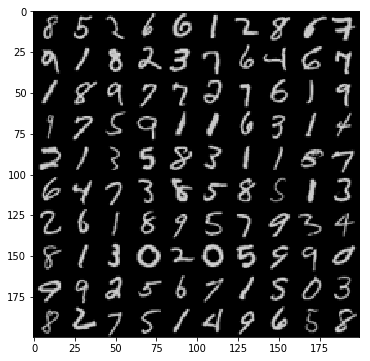

In [4]:
# print a random sample of numbers
displayData()

## One-hot encoding of 'y'

We need to one-hot encode our y labeles. Rights now y is a [5000x1] array where each element contains a number in the range (1...10) that represents the handwritten number of the corresponding training sample (note the '10' represents the '0').

With a one-hot encoding we transform each element of y into an array with 10 elements where each one is a binary representation of each label. This way, a sample labeled as '3' will have the 3rd bit hot ('1') and the rest 'cold' (0).

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [6]:
y[3245], y_onehot[3245]

(array([6], dtype=uint8), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

## Cost Computation (Forward propagation)

Let's first implement the functions that are required to implement the cost.

The cost function evaluates how a given set of parameters theta represents a good model. To compute the cost we inject the input features X to the network and apply the Forward Propagation algorithm to obtain the predicted classifications (h). The cost function summarizes the differences between the predicted and the real classifications.

In [7]:
# sigmoid function definition
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
# Function that receives as input:
#   - X[ num_samples x num_features ]
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels x num_L2_units_with_bias ]
# and returns:
#   - all the forward propagation steps
#     - a1 [ num_samples x (num_features+1) ]
#     - z2 [ num_samples x num_L2_units_no_bias ]
#     - a2 [ num_samples x num_L2_units_with_bias ]
#     - z3 [ num_samples x num_output_labels ]
#     - h  [ num_samples x num_output_labels ]
def forward_propagate(X, theta1, theta2):   
    # Your code here for Problem 1.3
    a1=np.insert(X,0,values=np.ones(X.shape[0]),axis=1)
    z2=np.dot(a1,theta1.T)
    a2=np.insert(sigmoid(z2),0,values=np.ones(sigmoid(z2).shape[0]),axis=1)
    z3=np.dot(a2,theta2.T)
    h=sigmoid(z3)
    return a1, z2, a2, z3, h

In [9]:
# Function that receives as input:
#   - y[ num_samples x num_labels ] (one-hot encoded)
#   - h[ num_samples x num_labels ]
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels_ x num_L2_units_with_bias ]
#   - learning_rate (scalar for the regularization term)
# and returns: 
#   - the computed regularized cost J
def cost(y, h, theta1, theta2, learning_rate):    
    # Your code here for Problem 1.3
    a1, z2, a2, z3,h=forward_propagate(X, theta1, theta2)
    m=len(y)
    #cost function
    total=(-np.sum(np.multiply(y,np.log(h)))-np.sum(np.multiply(1-y,np.log(1-h))))/m  
    regularization=(learning_rate/(2*m))*(np.sum(np.square(theta1[:,1:]))+np.sum(np.square(theta2[:,1:])))
    J=total+regularization   
    
    return J

In [10]:
# Function that receives as input:
#   - X[ num_samples x num_features ]
#   - y[ num_samples x num_labels ] (one-hot encoded)
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels_ x num_L2_units_with_bias ]
#   - learning_rate (scalar for the regularization term)
# and returns: 
#   - the computed regularized cost J
#   - all the forward propagation steps (a1, z2, a2, z3, h)
def forward_and_cost(X, y, theta1, theta2, learning_rate):
    
    m = X.shape[0]
    
    # convert to matrices to use notation of algebra operations
    X = np.matrix(X)
    y = np.matrix(y)
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    # run the (vectorized) forward propagation
    #     - a1 [ num_samples x (num_features+1) ]
    #     - z2 [ num_samples x num_L2_units_no_bias ]
    #     - a2 [ num_samples x num_L2_units_with_bias ]
    #     - z3 [ num_samples x num_output_labels ]
    #     - h  [ num_samples x num_output_labels ]
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost given comparing y and h
    J = cost(y, h, theta1, theta2, learning_rate)
    
    return J, a1, z2, a2, z3, h


### Test the cost calculation: random theta

Let's quickly test this cost function calculation with a set of random theta parameters.

We will initialize the theta parameters to a random value in the range [-e, +e] (with epsilon e = 0.12). This range of values ensures that the parameters are kept small and makes the learning more efficient. In out code we will use [-0.12, +0.12] for all theta.

In [11]:
# randomly initialize a the theta parameters arrays
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels x num_L2_units_with_bias ]
theta1_temp = (np.random.random(size=25*(400+1)) - 0.5) * 0.24
theta1      = np.reshape(theta1_temp[:25*(400+1)],(25,(400+1)))
theta2_temp = (np.random.random(size=10*(25+1)) - 0.5) * 0.24
theta2      = np.reshape(theta2_temp[:10*(25+1)],(10,(25+1)))
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [12]:
# Now let's compute the cost (without regularization)
J, a1, z2, a2, z3, h = forward_and_cost(X, y_onehot, theta1, theta2, 0)
J

6.7046442279539

In [13]:
# Now let's compute the cost (with regularization)
J, a1, z2, a2, z3, h = forward_and_cost(X, y_onehot, theta1, theta2, 1)
J

6.7096012140302355

Well, at least it didn't crash, and the cost is always around 6-7.

### Test the cost calculation: precomputed theta

Let's quickly test this cost function calculation with the set of precomputed (default) theta parameters.

In [14]:
from scipy.io import loadmat
thetas = loadmat('hw6_weights.mat')
theta1, theta2 = thetas['Theta1'], thetas['Theta2']

In [15]:
# Now let's compute the cost (without regularization)
J, a1, z2, a2, z3, h = forward_and_cost(X, y_onehot, theta1, theta2, 0)
J

0.28762916516131887

In [16]:
# Now let's compute the cost (with regularization)
J, a1, z2, a2, z3, h = forward_and_cost(X, y_onehot, theta1, theta2, 1)
J

0.3837698590909236

This looks better. Much lower cost compared to random initialization of thetas

## Gradient Computation (BackPropagation)

In order to train the NN, we need to minimize J. To do that we need J (we have it!) and its gradient (about to have it!).

Now let's implement the code that computes the gradient of J that we need to train the NN. This gradient will be fed to a minimization function from a third party library.

We use the backpropagation algorithm to compute the gradient of J.

In [17]:
# function that returns the sigmoid gradient => g(1-g)
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [18]:
# randomly initialize a the theta parameters arrays
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels x num_L2_units_with_bias ]
theta1_temp = (np.random.random(size=25*(400+1)) - 0.5) * 0.24
theta1      = np.reshape(theta1_temp[:25*(400+1)],(25,(400+1)))
theta2_temp = (np.random.random(size=10*(25+1)) - 0.5) * 0.24
theta2      = np.reshape(theta2_temp[:10*(25+1)],(10,(25+1)))
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [19]:
# Function that receives as input:
#   - theta2 [ num_output_labels x num_L2_units_with_bias ]
#   - a1 [ num_samples x (num_features+1) ]
#   - z2 [ num_samples x num_L2_units_no_bias ]
#   - a2 [ num_samples x num_L2_units_with_bias ]
#   - h  [ num_samples x num_output_labels ]
#   - y  [ num_samples x num_output_labels ]
def gradient(theta2, a1, z2, a2, h, y, learning_rate):
    
    # initialize variables
    m = a1.shape[0]
    delta1 = np.zeros(theta1.shape)  # [ num_L2_units_no_bias x (num_features+1) ]
    delta2 = np.zeros(theta2.shape)  # [ num_output_labels x num_L2_units_with_bias ]
    
    # loop all training samples
    for s in range(m):
        
        # get intermediate values for the given sample 's'
        a1s = a1[s,:]  # [ 1 x (num_features+1) ]
        z2s = z2[s,:]  # [ 1 x num_L2_units_no_bias ]
        a2s = a2[s,:]  # [ 1 x num_L2_units_with_bias ]
        hs = h[s,:]    # [ 1 x num_output_labels ]
        ys = y[s,:]    # [ 1 x num_output_labels ]
        
        # compute error at output layer (layer 3)
        d3s = hs - ys  # [ 1 x num_output_labels ]
        
        # compute error at layer 2
        z2s = np.insert(z2s, 0, values=np.ones(1))  # insert bias unit => [ 1 x num_L2_units_with_bias ]
        d2s = np.multiply((theta2.T * d3s.T).T, sigmoid_gradient(z2s))  #  [ 1 x num_L2_units_with_bias ]
        d2s = d2s[:,1:] # discard d2s[0] => [ 1 x num_L2_units_with_no_bias ]
        
        # accumulate errors into delta matrices
        delta1 = delta1 + d2s.T * a1s 
        delta2 = delta2 + d3s.T * a2s
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term (note we do not sum the theta for the bias units)
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    return delta1, delta2

In [20]:
# compute gradient without regularization
delta1, delta2 = gradient(theta2, a1, z2, a2, h, y, 0)
delta1.shape, delta2.shape

((25, 401), (10, 26))

In [21]:
# compute gradient with regularization
delta1, delta2 = gradient(theta2, a1, z2, a2, h, y, 0)
delta1.shape, delta2.shape

((25, 401), (10, 26))

## Train the Neural Network

We have al the pieces ready to train the NN:
- Cost J
- Gradient of J (delta1 and delta2)

We will use a third party optimization algorithm to minimize J and get the final theta values.

In [22]:
# in order to use the scipy minimize function we need to provide a function that computes J and gradient, 
# and is passsed an unrolled version of the parameters theta to optimize
def objective_function(thetas, X, y, learning_rate):
    
    # set variables
    input_size = 400
    hidden_size = 25
    output_size = 10
    
    # convert the thetas array into theta matrices for each layer
    theta1 = np.matrix(np.reshape(thetas[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(thetas[hidden_size * (input_size + 1):], (output_size, (hidden_size + 1))))

    # forward propagation to compute h (and intermediate steps) and
    # cost computation
    J, a1, z2, a2, z3, h = forward_and_cost(X, y, theta1, theta2, learning_rate)
    
    # compute the gradient of J
    delta1, delta2 = gradient(theta2, a1, z2, a2, h, y, learning_rate)

    # convert the gradient matrices (delta1, delta2) into a single gradient array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [23]:
# randomly initialize a the theta parameters arrays
#   - theta1[ num_L2_units_no_bias x (num_features+1) ]
#   - theta2[ num_output_labels x num_L2_units_with_bias ]
theta1_temp = (np.random.random(size=25*(400+1)) - 0.5) * 0.24
theta1      = np.reshape(theta1_temp[:25*(400+1)],(25,(400+1)))
theta2_temp = (np.random.random(size=10*(25+1)) - 0.5) * 0.24
theta2      = np.reshape(theta2_temp[:10*(25+1)],(10,(25+1)))

# convert theta1 and theta2 to a single array to feed the objective function minimization
thetas = np.concatenate((np.ravel(theta1), np.ravel(theta2)))

theta1.shape, theta2.shape, thetas.shape

((25, 401), (10, 26), (10285,))

In [24]:
from scipy.optimize import minimize

# minimize the objective function
# - fun = function that computes the cost and the gradient and returns ???
# - x0 = initial guess of theta (first argument of fun)
# - args = rest of arguments of fun
# - method = optimization method (TNC: Truncated Newton)
# - jac = true to indicate that we provide the gradient (Jacobian)
# - options - maxiter = maximum number of optimization iterations
learning_rate = 1
fmin = minimize(fun=objective_function, 
                x0=thetas, 
                args=(X, y_onehot, learning_rate), 
                method='TNC', 
                jac=True, 
                options={'maxiter': 250, 'disp': True}
               )
fmin

     fun: 0.4324855060258651
     jac: array([ 1.02938014e-04,  1.92274607e-05,  1.13602130e-05, ...,
        6.60099243e-06, -2.14051991e-04,  9.46166852e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 17
  status: 3
 success: False
       x: array([ 1.76215898,  0.00998349,  0.00948653, ...,  0.63590659,
       -1.17145407, -1.20974649])

In some executions we have reached the maximum number of iterations before the algorithm converged (this is why it is sometimes marked as success: false). Nevertheless, a cost below 0.5 indicates us that the algorithm is working and would get lower with more iterations. **It is very important to note that running "fmin = minimize()" may take much time (for example, 20-40 minutes, depending on your computer)**.

Let's test the returned set of thetas to make some predictions.

## Classification (prediction)

In [25]:
# convert the thetas array into theta matrices for each layer
input_size = 400
hidden_size = 25
output_size = 10
thetas = fmin.x
theta1 = np.matrix(np.reshape(thetas[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(thetas[hidden_size * (input_size + 1):], (output_size, (hidden_size + 1))))

In [26]:
# Propagate forward and predict y
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_predictions = np.array(np.argmax(h, axis=1) + 1)
y_predictions

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int32)

In [27]:
# Compute accuracy
num_correct = 0
incorrect_indices = []
for sample in range(y_predictions.shape[0]):
    if(y[sample].item(0) == y_predictions[sample]):
        # print "original: ",y[sample].item(0)," | predicted: ", labels[np.argmax(h)]," RIGHT"
        num_correct = num_correct + 1
    else:
        #print "original: ",y[sample].item(0)," | predicted: ", labels[np.argmax(h)]," WRONG"
        incorrect_indices.append(sample)

In [28]:
# Compute accuracy of the classifier
accuracy = float(num_correct) / (num_correct + len(incorrect_indices))
print('Accuracy = {0}%'.format(accuracy * 100))

Accuracy = 98.68%


98.9%! :)
- Better than the 94.4% of the Logistic Regression classifier
- Better than the 97.5% of the Neural Network with the provided parameters

## Visualization of the wrong classification

In [29]:
import scipy.misc #Used to show matrix as an image
import random #To pick random images to display
import matplotlib.cm as cm #Used to display images in a specific colormap

def getDatumImg(row):
    # Function that is handed a single np array with shape 1x400, creates an image object from it, and returns it
    width, height = 20, 20
    square = row[0:].reshape(width,height)
    return square.T

def displayData(indices_to_display = None):
    # Function that picks 100 random rows from X, creates a 20x20 image from each, then stitches them together into a 10x10 grid of images, and shows it
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

[[ 6  4  6  6  8  4  5 10  4  4]]
[[8 3 3 7 2 9 7 8 7 5]]
[[ 9  2  5  9  6  1  9  9 10  9]]
[[ 9  3  7  3 10  9  6  4  5  1]]


c:\users\alice\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


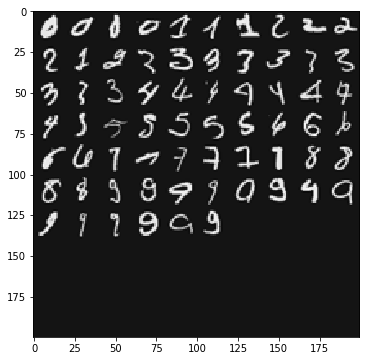

In [30]:
# Visualization of the wrong predictions
displayData(incorrect_indices)
y_predictions_np = np.array(y_predictions)
print(y_predictions_np[incorrect_indices[0:10]].T)
print(y_predictions_np[incorrect_indices[10:20]].T)
print(y_predictions_np[incorrect_indices[20:30]].T)
print(y_predictions_np[incorrect_indices[30:40]].T)

Definetely some of the missclassified numbers were written not very clerly.

## Visualize the hidden layer

In [31]:
def displayHiddenLayer(theta1):
    # Function that takes slices of theta1, removes the bias unit, and reshapes it into a 20x20 image, and shows it
    
    #remove bias unit:
    theta1 = theta1[:,1:]
    assert theta1.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for row in theta1:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(row)
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.seismic)

c:\users\alice\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


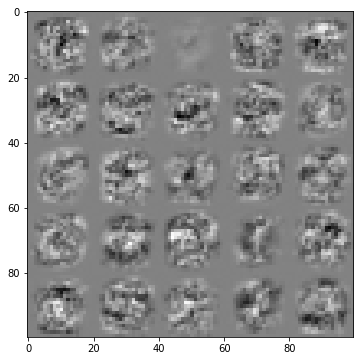

In [32]:
displayHiddenLayer(theta1)

Here we are actually visualizing the structure of theta1. Hence, what we see in the image is what theta1 interprets from the input samples and delivers to the hidden unit. 

Each one of the 25 rounded shapes represents one of the 25 hidden units.
While it might seem just a bunch of blurred images, they really tell what pattern (strokes) each unit is detecting. 